In [10]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import scikitplot as skplt
import matplotlib.pyplot as plt
#import matplotlib.spines as spn
from sklearn import metrics
import seaborn as sns

In [11]:
# Load data #
data=pd.read_csv("merged.csv")

#  Print columns of dataset with missing values #
list = data.columns[data.isna().any()].tolist()
print(list)

# Fill NA values with mean of the corresponding column #
for i in list:
    print(i)
    print(data.isna().sum())                      # See how many values are null in that column
    data[i].fillna(data[i].mean(), inplace=True)  # If below a threshold fill with column mean

[]


In [12]:
# Set feature and target columns #
features = data.drop(['step','labels'], axis=1)
target = data['labels']
#print(features.head(n=5))
#print(target.head(n=5))

# Train test split and scale data #
X1,X2,y1,y2 =train_test_split(features, target, stratify=target, test_size= 0.30, random_state=793)
scaler = StandardScaler()
x1 = pd.DataFrame(scaler.fit_transform(X1))                
x2 = pd.DataFrame(scaler.transform(X2))
#print(x1.shape, x2.shape, y1.shape, y2.shape)
#print(x1.head(n=5),y1.head(n=5))
#print(x2.head(n=5),y2.head(n=5))

# To perform cross validation on train set #
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

In [13]:
# BASE MODEL evaluation #
RF = RandomForestClassifier
base_model = RF(n_estimators=100, random_state=42)

accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []

# Model evaluation for cross validation on TRAINING DATASET #

for train_index, test_index in cv.split(x1,y1):
    #print(len(train_index))
    #print(len(test_index))
    X_train, X_test = x1.iloc[train_index], x1.iloc[test_index]
    y_train, y_test = y1.iloc[train_index], y1.iloc[test_index]
    base_model.fit(X_train, y_train)
    y_pred = base_model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    
    accuracy_scores.append(acc)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    specificity_scores.append(specificity)
    
avg_acc=np.mean(accuracy_scores)
avg_f1=np.mean(f1_scores)
avg_precision=np.mean(precision_scores)
avg_recall=np.mean(recall_scores)
avg_specificity=np.mean(specificity_scores)

scoredata = pd.DataFrame()
valscoredict = {'Data':'Validation','score_accuracy':avg_acc,'score_f1':avg_f1,'score_precision':avg_precision,'score_recall':avg_recall, 'score_specificity': avg_specificity}
scoredata=scoredata.append(valscoredict, ignore_index = True)
#print(scoredata)

# Model evaluation on TEST DATASET #

base_model.fit(x1, y1)
y2_base_predict = pd.Series(base_model.predict(x2))

cm = confusion_matrix(y2, y2_base_predict)
base_test_accuracy = accuracy_score(y2, y2_base_predict)
base_test_f1 = f1_score(y2, y2_base_predict)
base_test_precision = precision_score(y2, y2_base_predict)
base_test_recall = recall_score(y2, y2_base_predict)
base_test_specificity = cm[0,0]/(cm[0,0]+cm[0,1])

testscoredict = {'Data':'Test','score_accuracy':base_test_accuracy,'score_f1':base_test_f1,'score_precision':base_test_precision,'score_recall':base_test_recall, 'score_specificity': base_test_specificity}
scoredata=scoredata.append(testscoredict, ignore_index = True)
#print(scoredata)

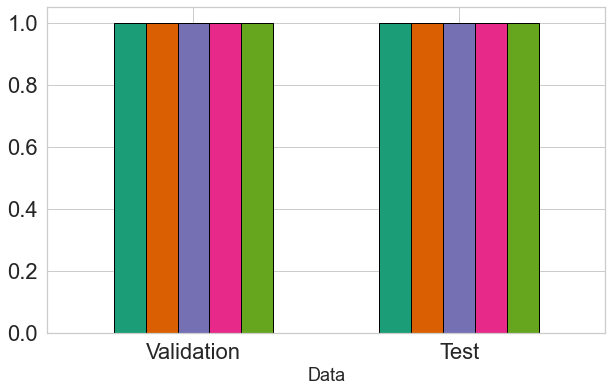

No handles with labels found to put in legend.


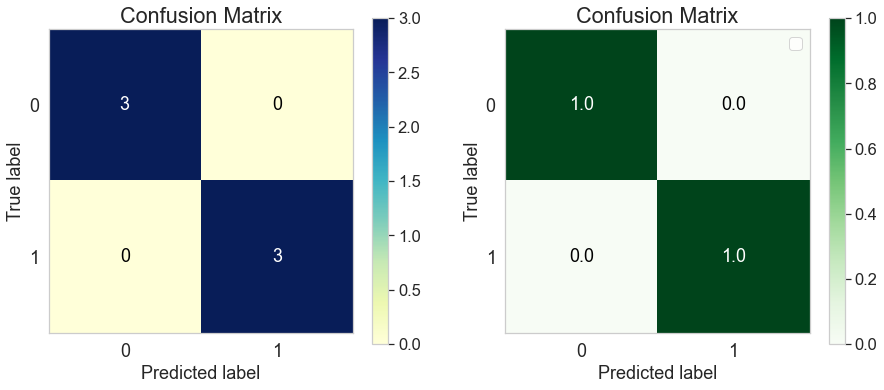

In [14]:
## PLOTS for BASE MODEL ##
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")

# Plot scores # 
c = plt.get_cmap('Dark2')
scoredata.plot.bar(x="Data", rot=0, width=0.6, figsize=(10,6), fontsize=22, legend=False, edgecolor="black", linewidth=1, color = c.colors)
#plt.savefig("barplot.png", dpi=300)
plt.show()

# Plot Confusion Matrix #
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
skplt.metrics.plot_confusion_matrix(y2, y2_base_predict,
                                    title="Confusion Matrix",
                                    cmap="YlGnBu", 
                                    ax=ax1)
ax2 = fig.add_subplot(122)
skplt.metrics.plot_confusion_matrix(y2, y2_base_predict,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Greens",
                                    ax=ax2);
plt.legend(fontsize=16)
#fig.savefig("confusion-matrix.png", dpi=300)

35-292     0.01
51-193     0.01
81-106     0.01
237-276    0.01
230-250    0.01
           ... 
77-258     0.00
77-259     0.00
77-260     0.00
77-261     0.00
302-303    0.00
Name: Importance, Length: 38226, dtype: float64
         Importance  Cumulative
35-292         0.01        0.01
51-193         0.01        0.02
81-106         0.01        0.03
237-276        0.01        0.04
230-250        0.01        0.05
...             ...         ...
120-226        0.01        0.94
113-127        0.01        0.95
74-109         0.01        0.96
156-299        0.01        0.97
77-299         0.01        0.98

[98 rows x 2 columns]


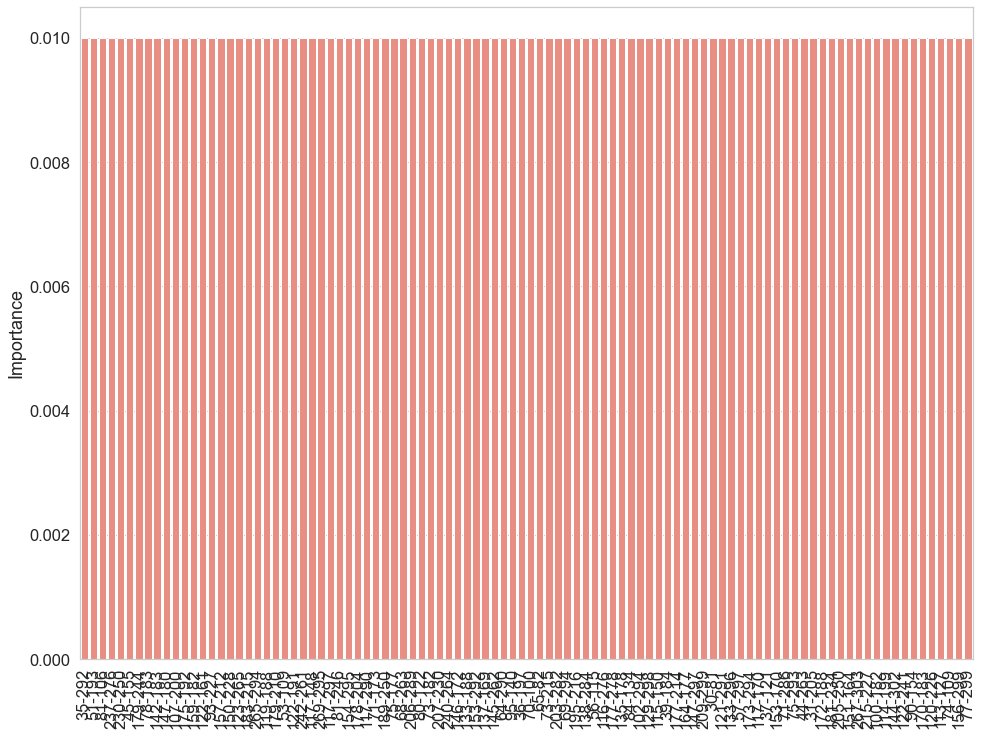

In [16]:
# Extract feature importance #
feature_imp = pd.Series(base_model.feature_importances_, index=features.columns, name='Importance').sort_values(ascending=False)
imp = feature_imp
print(imp)

cumsum = pd.Series(imp.cumsum(),name='Cumulative')
mergedscore = pd.DataFrame(pd.concat([feature_imp, cumsum], axis=1))
mergedscore.to_csv("featurerank.csv", sep=",")

filt = (mergedscore['Cumulative'] < 0.99)
df1 = mergedscore[filt]
print(df1)

# Feature Importance Plot #
plt.figure(figsize=(16,12))
sns.barplot(x=df1.index, y=df1['Importance'], data=df1, color="salmon")
plt.xticks(rotation='vertical')
plt.savefig("basemodel-featureimp.png", dpi=300)
plt.show()

In [17]:
# Pre-screening step (Phase I feature extraction to a new reduced dataset) #
list = df1.index
df2 = features[list]
screened= pd.concat([df2, data['labels']], axis=1)
#print(screened)
screened.to_csv("screened.csv", sep=",") # Repeat the same classification (script) using this reduced dataset #